## **1. Instalación e Importaciones**

In [91]:

!pip install missingno MissForest
!pip install missingpy
!pip install sklearn-impute

ERROR: Could not find a version that satisfies the requirement sklearn-impute (from versions: none)
ERROR: No matching distribution found for sklearn-impute


In [92]:
import pandas as pd
import missingno as msno
from sklearn.model_selection import train_test_split
from missforest import MissForest
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
import lightgbm as lgb
import shap
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.tools import add_constant


## **2. Subir el Dataset**

In [93]:
from google.colab import files
uploaded = files.upload()

Saving internal-link.csv to internal-link (1).csv


## **3. Abrir el Dataset**

In [94]:
df = pd.read_csv('internal-link.csv')
df.set_index('id', inplace=True)
pd.set_option('display.max_columns', None)
df.head(20)

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,,
2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0
5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220
5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,2017-07-21,0.99,1,0


In [95]:
df.shape

(48895, 15)

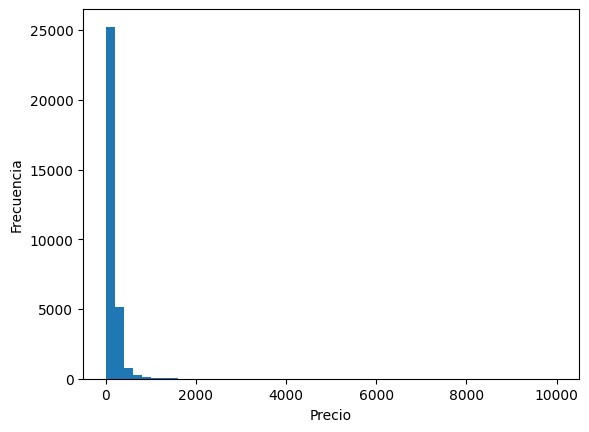

In [96]:
plt.hist(y_train_clean, bins=50)
plt.xlabel("Precio")
plt.ylabel("Frecuencia")
plt.show()

## **4. Identificar columnas con columnas constantes**   No tenemos columnas con valores constantes

In [97]:
unicos = df.nunique()
df[unicos[unicos==1].index]
df[unicos[unicos==1].index].head(5)

""
id
2539
2595
3647
3831
5022


## **5.. Eliminamos filas y columnas duplicadas** No Eliminamos ninguna.

In [98]:
df.duplicated().sum()

np.int64(0)

In [99]:
df.T.duplicated().sum()

np.int64(0)

In [100]:
df.T.duplicated(keep=False)

,0
name,False
host_id,False
host_name,False
neighbourhood_group,False
neighbourhood,False
latitude,False
longitude,False
room_type,False
price,False
minimum_nights,False


## **6. Eliminar columnas redundantes** Cuantificamos si Host_id tienen los mismos host_name. y sale ok.

In [101]:
df.groupby('host_id')['host_name'].nunique()

,host_name
host_id,
2438,1
2571,1
2787,1
2845,1
2868,1
...,...
274273284,1
274298453,1
274307600,1


In [102]:
df.groupby('host_id')['host_name'].nunique().loc[lambda x: x > 1]

,host_name
host_id,


Analizamos si Host_name tienen el mismo dueño. Me sale falso.

In [103]:
df.groupby('host_name')['name'].nunique()

,name
host_name,
'Cil,1
(Ari) HENRY LEE,1
(Email hidden by Airbnb),6
(Mary) Haiy,1
-TheQueensCornerLot,1
...,...
단비,1
빈나,1
소정,2


In [104]:
df.groupby('host_name')['name'].nunique().loc[lambda x: x > 1]

,name
host_name,
(Email hidden by Airbnb),6
475,4
@ Art House Monique,4
A,10
A. Kaylee,3
...,...
祥茵,2
美德,5
铀 Yuli,3


In [105]:
df.drop(['host_id','name', 'host_name'], axis=1, inplace=True)

## **7. Eliminar columnas Data leakage**


In [106]:
##df.drop(['price'], axis=1, inplace=True)

## **8. Valores faltantes por columna** Tiene que ser mayor a 40 % Para poder eliminarlas
mnar, mar, mcar... No eliminamos ninguna.

In [107]:
df.shape

(48895, 12)

In [108]:
faltantes = df.isna().mean()*100
faltantes[faltantes>0]

,0
last_review,20.558339
reviews_per_month,20.558339


## **9. Valores faltantes por filas**. Se mira cuantas valores faltantes hay en las viviendas. No eliminamos ninguna

In [109]:
df.isnull().any(axis=1).sum()

np.int64(10052)

**Se mira que vivienda tiene al menos 2 valores faltantes. Si tuviese mas de la mitad de valores faltantes, se evalua eliminar la vivienda**

In [110]:
n = 2
df[df.isnull().sum(axis=1) ==n]

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,
3647,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
7750,Manhattan,East Harlem,40.79685,-73.94872,Entire home/apt,190,7,0,NaN,NaN,2,249
8700,Manhattan,Inwood,40.86754,-73.92639,Private room,80,4,0,NaN,NaN,1,0
11452,Brooklyn,Bedford-Stuyvesant,40.68876,-73.94312,Private room,35,60,0,NaN,NaN,1,365
11943,Brooklyn,Flatbush,40.63702,-73.96327,Private room,150,1,0,NaN,NaN,1,365
...,...,...,...,...,...,...,...,...,...,...,...,...
36484665,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
36485057,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
36485431,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27


<Axes: >

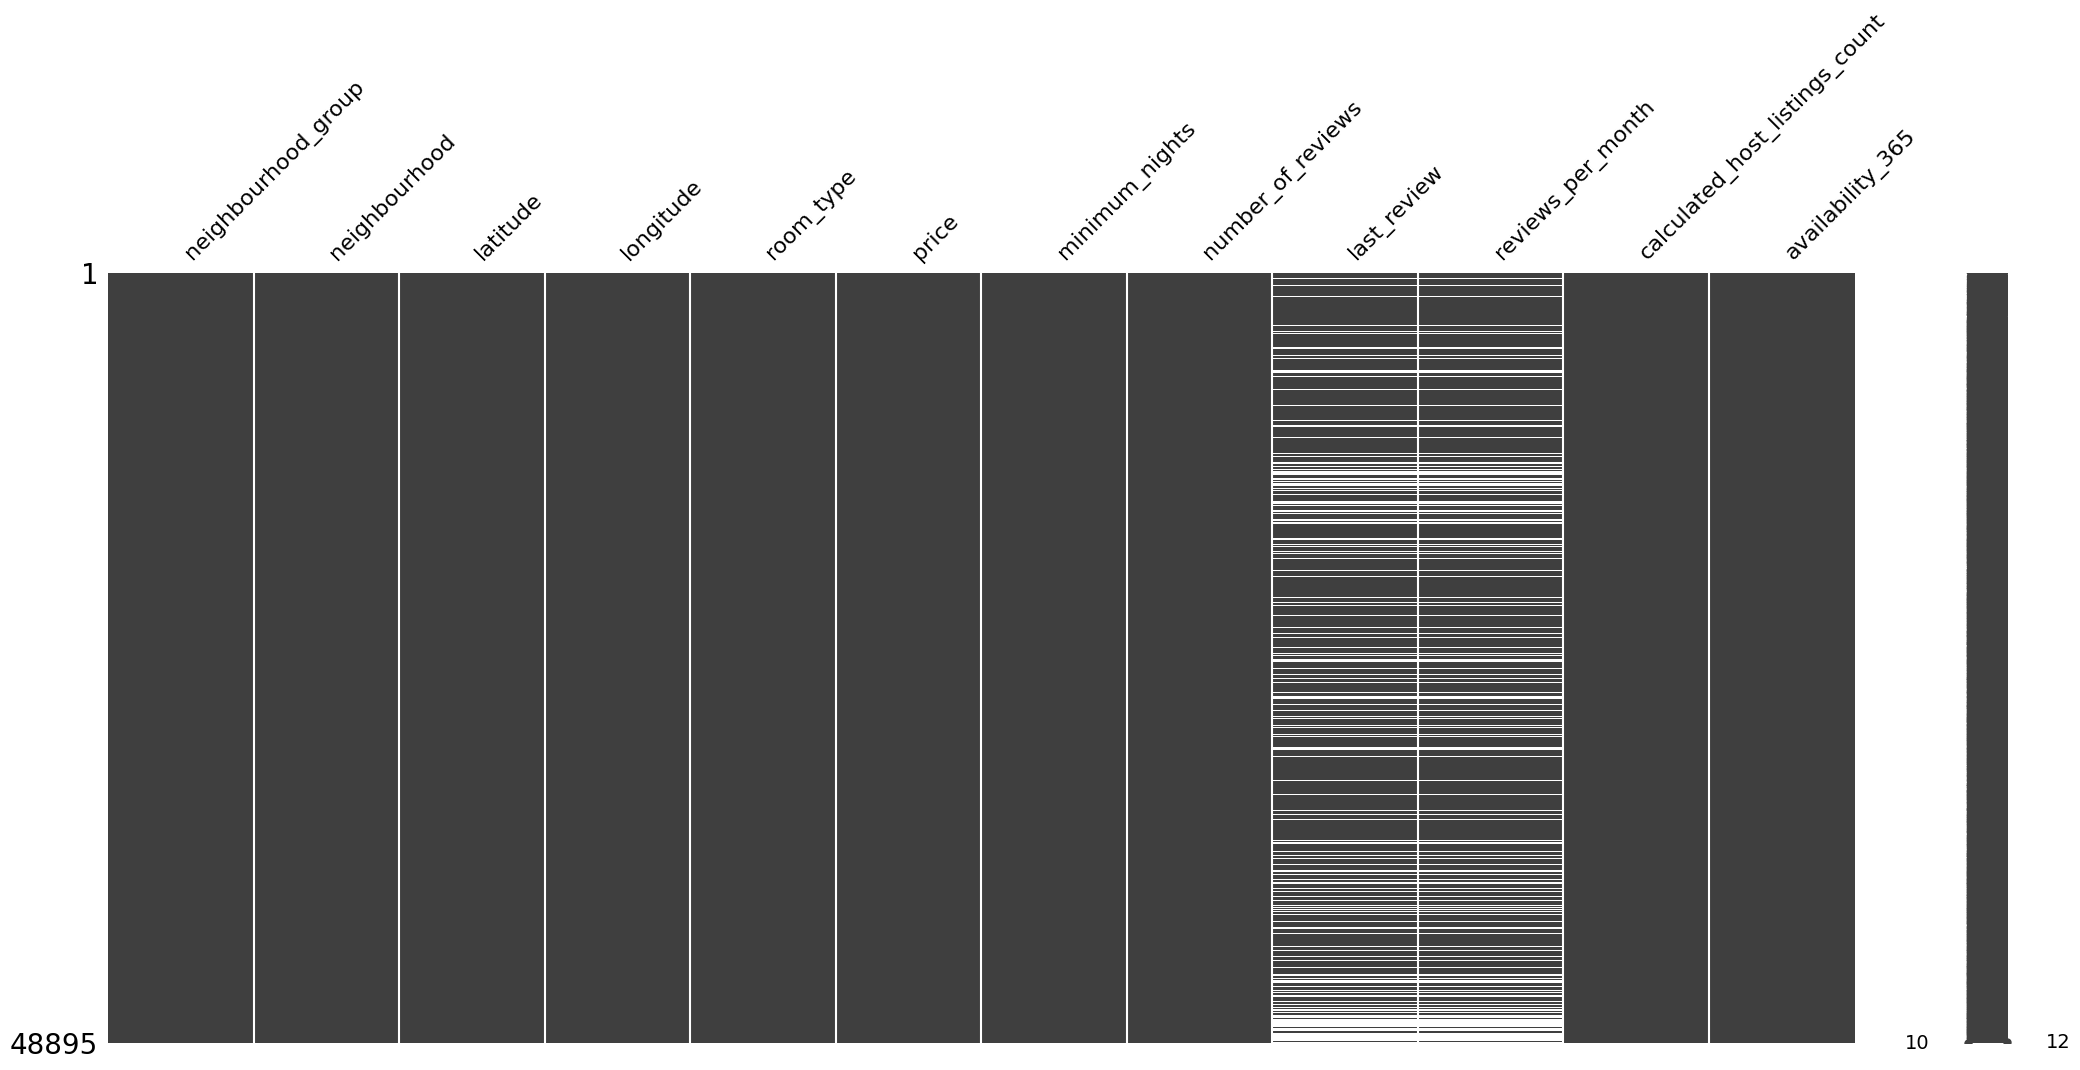

In [111]:
msno.matrix(df)

In [112]:
df.shape

(48895, 12)

## **10. Imputar**

Analisis:  Rellenamos reviews por Months con cero. Porque coincide que las que tienen NAN. no hay opiniones y eso se ve en la columna Numero de Opiniones

In [113]:
reviews_nan = df[df['reviews_per_month'].isnull()]
all_zero = (reviews_nan['number_of_reviews'] == 0).all()
print(all_zero)

True


In [114]:
df["reviews_per_month"] = df["reviews_per_month"].fillna(0)

**Comprobamos que Todos los Nan de reviews_per_month esten rellenados con cero

In [115]:
df["reviews_per_month"].isna().sum()

np.int64(0)

Para last_review Tenemos que Crear columna indicadora

In [116]:
print(df.columns)

Index(['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'last_review', 'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')


In [117]:
df["last_review_missing"] = df["last_review"].isna().astype(int)

In [118]:
df[["last_review", "last_review_missing"]].head()

,last_review,last_review_missing
id,,
2539,2018-10-19,0
2595,2019-05-21,0
3647,NaN,1
3831,2019-07-05,0
5022,2018-11-19,0


Eliminamos "last_review" porque creamos la columna indicadora last_review_missing.


In [119]:
df.drop('last_review', axis=1, inplace=True)

In [120]:
df.columns

Index(['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'last_review_missing'],
      dtype='object')

In [121]:
df.shape

(48895, 12)

## **11. Codificación de variables categóricas**
- map Género, 1,2,3. - target encoding. - frecuency encoding.
- one-hot encoding



In [122]:
df.dtypes


,0
neighbourhood_group,object
neighbourhood,object
latitude,float64
longitude,float64
room_type,object
price,int64
minimum_nights,int64
number_of_reviews,int64
reviews_per_month,float64
calculated_host_listings_count,int64


In [123]:
categoricas = df.select_dtypes(include=['object', 'category']).columns
print(categoricas)

Index(['neighbourhood_group', 'neighbourhood', 'room_type'], dtype='object')


In [124]:
print("Número de categorías únicas:")
print("neighbourhood_group:", df['neighbourhood_group'].nunique())
print("neighbourhood:", df['neighbourhood'].nunique())
print("room_type:", df['room_type'].nunique())

Número de categorías únicas:
neighbourhood_group: 5
neighbourhood: 221
room_type: 3


1. neighbourhood_group**

In [125]:
precio_por_grupo = df.groupby('neighbourhood_group')['price'].describe()
print(precio_por_grupo)

                       count        mean         std   min   25%    50%  \
neighbourhood_group                                                       
Bronx                 1091.0   87.496792  106.709349   0.0  45.0   65.0   
Brooklyn             20104.0  124.383207  186.873538   0.0  60.0   90.0   
Manhattan            21661.0  196.875814  291.383183   0.0  95.0  150.0   
Queens                5666.0   99.517649  167.102155  10.0  50.0   75.0   
Staten Island          373.0  114.812332  277.620403  13.0  50.0   75.0   

                       75%      max  
neighbourhood_group                  
Bronx                 99.0   2500.0  
Brooklyn             150.0  10000.0  
Manhattan            220.0  10000.0  
Queens               110.0  10000.0  
Staten Island        110.0   5000.0  


Ordinal Encoding para neighbourhood_group

In [126]:
mapping = {
    'Bronx': 1,
    'Queens': 2,
    'Staten Island': 3,
    'Brooklyn': 4,
    'Manhattan': 5
}

df['neighbourhood_group_encoded'] = df['neighbourhood_group'].map(mapping)

2. neighbourhood: miramos cuantos registros hay en cada barrio. Hacemos LaBelEncoder


In [127]:
top_n = 20  # los 20 barrios con más registros
top_neigh = df['neighbourhood'].value_counts().nlargest(top_n).index
df[df['neighbourhood'].isin(top_neigh)]['neighbourhood'].value_counts()

,count
neighbourhood,
Williamsburg,3920
Bedford-Stuyvesant,3714
Harlem,2658
Bushwick,2465
Upper West Side,1971
Hell's Kitchen,1958
East Village,1853
Upper East Side,1798
Crown Heights,1564


In [128]:
filtrado_df = df[df['neighbourhood'].isin(top_neigh)]
print(f"Registros restantes: {filtrado_df.shape[0]}")

Registros restantes: 32206


In [129]:
le = LabelEncoder()
df['neighbourhood_encoded'] = le.fit_transform(df['neighbourhood'])
print(df[['neighbourhood', 'neighbourhood_encoded']].head())

     neighbourhood  neighbourhood_encoded
id                                       
2539    Kensington                    108
2595       Midtown                    127
3647        Harlem                     94
3831  Clinton Hill                     41
5022   East Harlem                     61


In [130]:
precio_por_grupo2 = df.groupby('neighbourhood')['price'].describe()
print(precio_por_grupo2)

                 count        mean         std    min     25%    50%     75%  \
neighbourhood                                                                  
Allerton          42.0   87.595238   73.048617   33.0   47.00   66.5  104.75   
Arden Heights      4.0   67.250000   18.300729   41.0   62.75   72.5   77.00   
Arrochar          21.0  115.000000  133.119120   32.0   34.00   65.0  125.00   
Arverne           77.0  171.779221  193.347902   35.0   75.00  125.0  200.00   
Astoria          900.0  117.187778  349.898287   25.0   60.00   85.0  120.00   
...                ...         ...         ...    ...     ...    ...     ...   
Windsor Terrace  157.0  138.993631   84.630532   38.0   77.00  123.0  160.00   
Woodhaven         88.0   67.170455   40.527335   10.0   45.00   52.0   70.25   
Woodlawn          11.0   60.090909   19.821476   29.0   42.50   68.0   73.50   
Woodrow            1.0  700.000000         NaN  700.0  700.00  700.0  700.00   
Woodside         235.0   85.097872   70.

room_type: Ordinal Encoding

In [131]:
precio_por_grupo3 = df.groupby('room_type')['price'].describe()
print(precio_por_grupo3)

                   count        mean         std  min    25%    50%    75%  \
room_type                                                                    
Entire home/apt  25409.0  211.794246  284.041611  0.0  120.0  160.0  229.0   
Private room     22326.0   89.780973  160.205262  0.0   50.0   70.0   95.0   
Shared room       1160.0   70.127586  101.725252  0.0   33.0   45.0   75.0   

                     max  
room_type                 
Entire home/apt  10000.0  
Private room     10000.0  
Shared room       1800.0  


In [132]:
mapping = {
    'Shared room': 0,
    'Private room': 1,
    'Entire home/apt': 2
}

df['room_type_encoded'] = df['room_type'].map(mapping)

**Quitar las columnas categoricas**

In [133]:
df.drop(['neighbourhood_group', 'neighbourhood', 'room_type'], axis=1, inplace=True)

## **12. Train test split**

In [134]:
X = df.drop('price',axis=1)
y = df['price']

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [136]:
X_train.columns

Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'last_review_missing',
       'neighbourhood_group_encoded', 'neighbourhood_encoded',
       'room_type_encoded'],
      dtype='object')

In [137]:
X_train.shape

(39116, 11)

## **13. Chequear los OUTLIERS**

In [138]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,39116.0,40.728927,0.054555,40.49979,40.690067,40.723035,40.763180,40.91306
longitude,39116.0,-73.952311,0.046029,-74.24285,-73.983080,-73.955750,-73.936498,-73.71299
minimum_nights,39116.0,7.144775,21.472973,1.00000,1.000000,3.000000,5.000000,1250.00000
number_of_reviews,39116.0,23.334978,44.499352,0.00000,1.000000,5.000000,24.000000,629.00000
reviews_per_month,39116.0,1.094376,1.604249,0.00000,0.040000,0.370000,1.590000,58.50000
calculated_host_listings_count,39116.0,7.188925,33.172629,1.00000,1.000000,1.000000,2.000000,327.00000
availability_365,39116.0,113.445368,131.846430,0.00000,0.000000,46.000000,229.000000,365.00000
last_review_missing,39116.0,0.207230,0.405327,0.00000,0.000000,0.000000,0.000000,1.00000
neighbourhood_group_encoded,39116.0,4.141374,1.043551,1.00000,4.000000,4.000000,5.000000,5.00000
neighbourhood_encoded,39116.0,107.302792,68.726630,0.00000,51.000000,94.000000,178.000000,220.00000


In [139]:
iso = IsolationForest(random_state=123)
df_num = X_train.copy()
df_num['outlier_flag'] = iso.fit_predict(X_train)

In [140]:
df_num['outlier_flag'].value_counts()

,count
outlier_flag,
1,31718
-1,7398


In [141]:
X_train_clean = df_num[df_num['outlier_flag'] == 1].drop(columns='outlier_flag')

In [142]:
y_train_clean = y_train.loc[X_train_clean.index]

## **14.Selección de características**

\\Método 1: Feature importance de RF



In [143]:
# Entrenamiento de RF
model = RandomForestRegressor(random_state=42,n_jobs=-1).fit(X_train_clean, y_train_clean)

In [144]:
# Importancia de características
importances = model.feature_importances_/model.feature_importances_.sum()*100

# Convertir a DataFrame
df_rf_imp = pd.DataFrame({'feature': X_train.columns,'rf_importance': importances}).sort_values(by='rf_importance', ascending=False)

# Calculamos la importancia acumulada
df_rf_imp['rf_importance_acum'] = df_rf_imp['rf_importance'].cumsum()

In [145]:
df_rf_imp

,feature,rf_importance,rf_importance_acum
1,longitude,25.411849,25.411849
0,latitude,21.575197,46.987045
6,availability_365,11.118512,58.105558
4,reviews_per_month,8.798129,66.903686
2,minimum_nights,7.568392,74.472078
10,room_type_encoded,7.258478,81.730556
5,calculated_host_listings_count,6.353337,88.083893
9,neighbourhood_encoded,6.087079,94.170972
3,number_of_reviews,4.367411,98.538382
7,last_review_missing,0.733518,99.271901


**Método 2: Permutation/Shuffle importance**

In [146]:
# Para esta técnica y la de shap se necesita conjunto de validación
X_train1, X_val, y_train1, y_val = train_test_split(X_train_clean, y_train_clean, test_size=0.2, random_state=42)

# Ajustamos el modelo
model_xgb = XGBRegressor(objective='reg:squarederror', random_state=42).fit(X_train1, y_train1)

In [147]:
# Realizamos 10 permutaciones por cada característica
perm = permutation_importance(model_xgb, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')

In [148]:
df_perm_imp = pd.DataFrame({'feature': X_train.columns, 'perm_imp': perm.importances_mean*100}).sort_values('perm_imp', ascending=False)
df_perm_imp

,feature,perm_imp
4,reviews_per_month,1.151043e+16
10,room_type_encoded,7.983957e+15
1,longitude,5.566298e+15
5,calculated_host_listings_count,4.721486e+15
0,latitude,4.336650e+15
9,neighbourhood_encoded,3.513396e+15
8,neighbourhood_group_encoded,1.053247e+15
3,number_of_reviews,1.015819e+15
7,last_review_missing,0.000000e+00
2,minimum_nights,-1.662237e+15


**Método 3: SHAP**

In [149]:
# Ajustamos el modelo
model_lgbm = lgb.LGBMRegressor(random_state=42, n_jobs=-1).fit(X_train1, y_train1)
explainer = shap.Explainer(model_lgbm, X_val)
shap_vals = explainer(X_val, check_additivity=False).values

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1408
[LightGBM] [Info] Number of data points in the train set: 25374, number of used features: 11
[LightGBM] [Info] Start training from score 156.255813


 99%|===================| 6294/6344 [00:26<00:00]       

In [150]:
imp_shap = np.abs(shap_vals).mean(axis=0)
imp_shap_pct = imp_shap/imp_shap.sum()*100
df_shap_imp = pd.DataFrame({"feature": X_val.columns, "shap_imp": imp_shap_pct}).sort_values('shap_imp', ascending=False)
df_shap_imp

,feature,shap_imp
10,room_type_encoded,33.858522
6,availability_365,15.559654
1,longitude,12.538739
0,latitude,7.316718
8,neighbourhood_group_encoded,6.087902
2,minimum_nights,5.615316
4,reviews_per_month,5.401790
3,number_of_reviews,5.126658
5,calculated_host_listings_count,4.447874
9,neighbourhood_encoded,4.046825


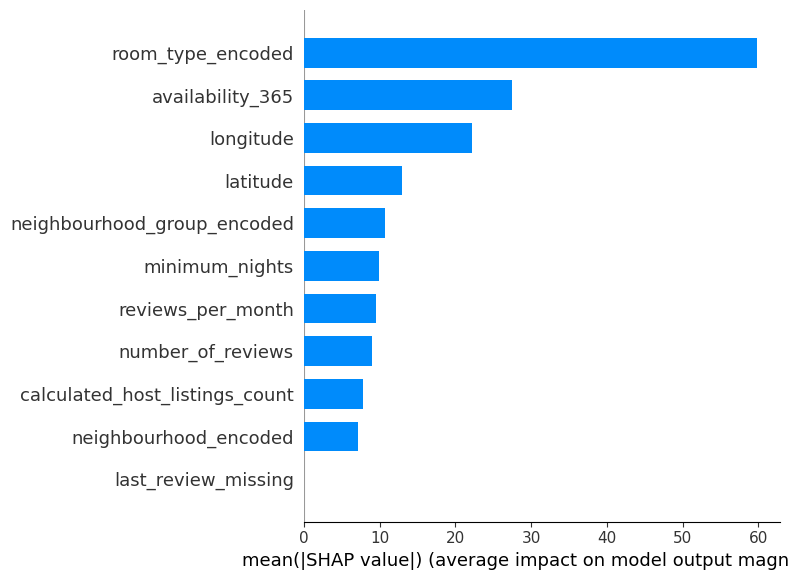

In [151]:
shap.summary_plot(shap_vals, X_val, plot_type="bar")

**Unión 3 métodos**

In [152]:
df_importances = (
    df_rf_imp
    .merge(df_perm_imp, on='feature', how='outer')
    .merge(df_shap_imp, on='feature', how='outer')
).sort_values('rf_importance', ascending=False)
df_importances

,feature,rf_importance,rf_importance_acum,perm_imp,shap_imp
4,longitude,25.411849,25.411849,5.566298e+15,12.538739
3,latitude,21.575197,46.987045,4.336650e+15,7.316718
0,availability_365,11.118512,58.105558,-1.721962e+15,15.559654
9,reviews_per_month,8.798129,66.903686,1.151043e+16,5.401790
5,minimum_nights,7.568392,74.472078,-1.662237e+15,5.615316
10,room_type_encoded,7.258478,81.730556,7.983957e+15,33.858522
1,calculated_host_listings_count,6.353337,88.083893,4.721486e+15,4.447874
6,neighbourhood_encoded,6.087079,94.170972,3.513396e+15,4.046825
8,number_of_reviews,4.367411,98.538382,1.015819e+15,5.126658
2,last_review_missing,0.733518,99.271901,0.000000e+00,0.000000


In [153]:
df_filt = df_importances[(df_importances['rf_importance']>=1)&(df_importances['perm_imp']>=1)&(df_importances['shap_imp']>=1)]
df_filt

,feature,rf_importance,rf_importance_acum,perm_imp,shap_imp
4,longitude,25.411849,25.411849,5.566298e+15,12.538739
3,latitude,21.575197,46.987045,4.336650e+15,7.316718
9,reviews_per_month,8.798129,66.903686,1.151043e+16,5.401790
10,room_type_encoded,7.258478,81.730556,7.983957e+15,33.858522
1,calculated_host_listings_count,6.353337,88.083893,4.721486e+15,4.447874
6,neighbourhood_encoded,6.087079,94.170972,3.513396e+15,4.046825
8,number_of_reviews,4.367411,98.538382,1.015819e+15,5.126658


##**15. VIF**

In [154]:
features = df_filt['feature']
features

,feature
4,longitude
3,latitude
9,reviews_per_month
10,room_type_encoded
1,calculated_host_listings_count
6,neighbourhood_encoded
8,number_of_reviews


In [155]:


X_vif = add_constant(X_train_clean[features])

vif = pd.Series([variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])],index=X_vif.columns)
vif = vif.drop("const")
vif

,0
longitude,1.082097
latitude,1.084866
reviews_per_month,1.435665
room_type_encoded,1.051544
calculated_host_listings_count,1.003237
neighbourhood_encoded,1.118434
number_of_reviews,1.429071


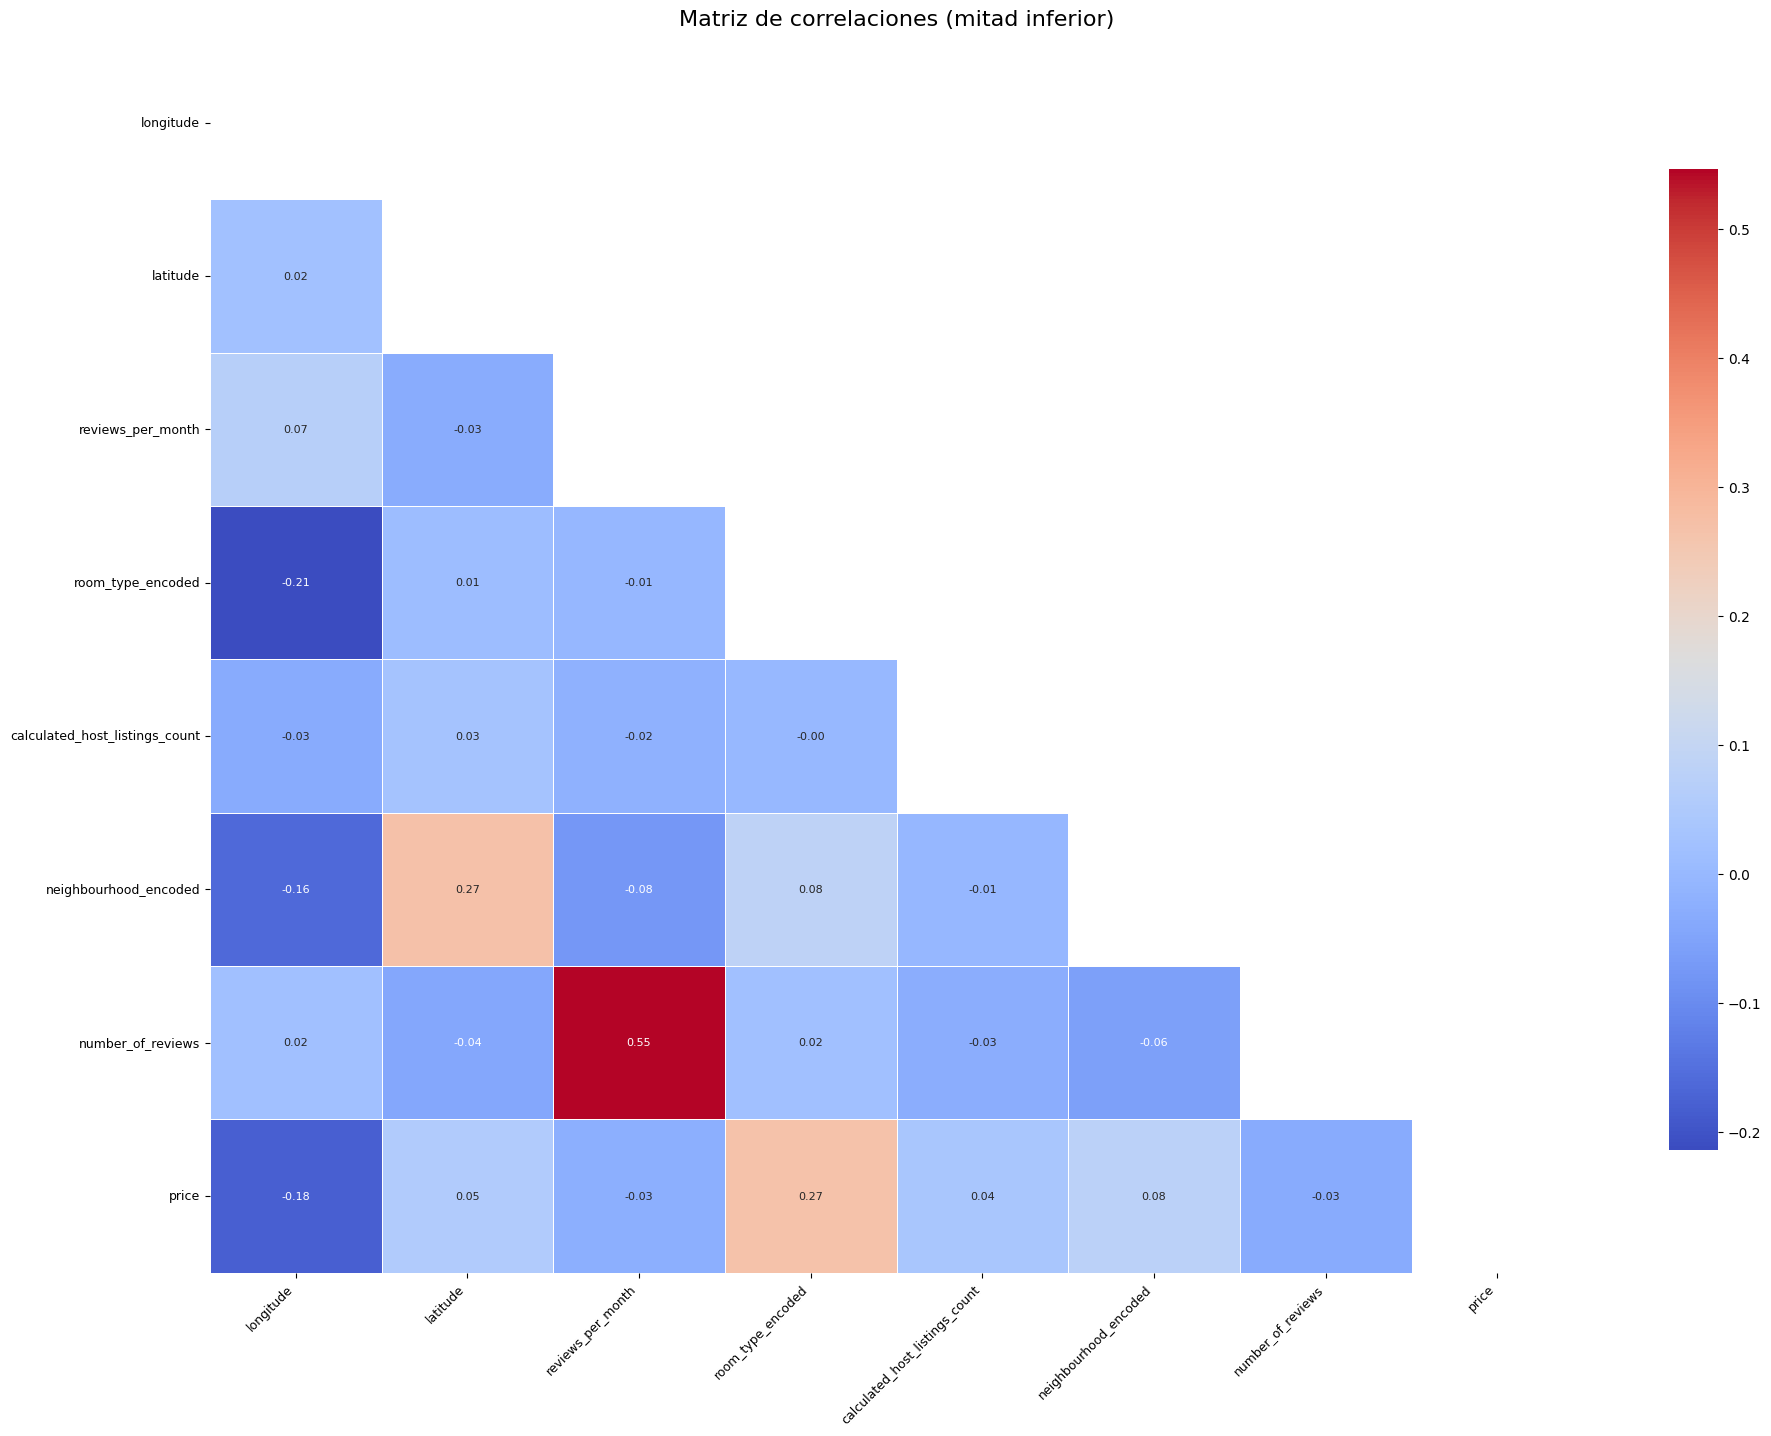

In [156]:
X_copy = X_train_clean[features].copy()
X_copy['price'] = y_train
corr = X_copy.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(20, 15))
sns.heatmap(
    corr, mask=mask, cmap='coolwarm',
    annot=True, fmt=".2f", linewidths=.5,
    cbar_kws={"shrink": .8},
    annot_kws={"size": 8}
)
plt.title("Matriz de correlaciones (mitad inferior)", fontsize=16, pad=15)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout(pad=3.0)
plt.show()

## **16.Cross_validation**


Si tenemos distintas hipótesis y no sabemos cual de ellas elegir una buena forma es realizar la validación cruzada. Que consiste en usar una parte de los datos de train para validar el algoritmo con los datos que le pasemos.

In [157]:
model = RandomForestRegressor(random_state=42, n_jobs=-1)

cv_results = cross_val_score(
    model,
    X_train_clean[features],
    y_train_clean,
    cv=3,
    scoring='neg_mean_absolute_percentage_error'
)


print("Media MAE:", -cv_results.mean())

Media MAE: 96781293133698.89


**Para Sacar las variables con Correlación**

In [158]:
 # Versión 2: Realizar cross_validation con  las características que son candidatas sin las correlacionadas
cv_results2 = cross_val_score(RandomForestRegressor(random_state=42,n_jobs=-1), X_train_clean[features].drop(['number_of_reviews',],axis=1), y_train_clean, cv=3, scoring='neg_mean_absolute_percentage_error')

In [159]:
cv_results2.mean()*-1

np.float64(98789031277085.56)

## **17.Modelado**

In [160]:
X_train_sel = X_train_clean[features]
X_test_sel = X_test[features]

In [161]:
X_train_sel.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,31718.0,-73.957834,0.033055,-74.17065,-73.98319,-73.957555,-73.941470,-73.72800
latitude,31718.0,40.727488,0.050548,40.57210,40.68961,40.721070,40.761567,40.88985
reviews_per_month,31718.0,0.935854,1.260294,0.00000,0.06000,0.365000,1.340000,10.00000
room_type_encoded,31718.0,1.525601,0.515690,0.00000,1.00000,2.000000,2.000000,2.00000
calculated_host_listings_count,31718.0,2.087048,4.444189,1.00000,1.00000,1.000000,2.000000,96.00000
neighbourhood_encoded,31718.0,106.855697,68.759417,4.00000,51.00000,94.000000,178.000000,220.00000
number_of_reviews,31718.0,18.325588,30.279003,0.00000,1.00000,5.000000,21.000000,248.00000


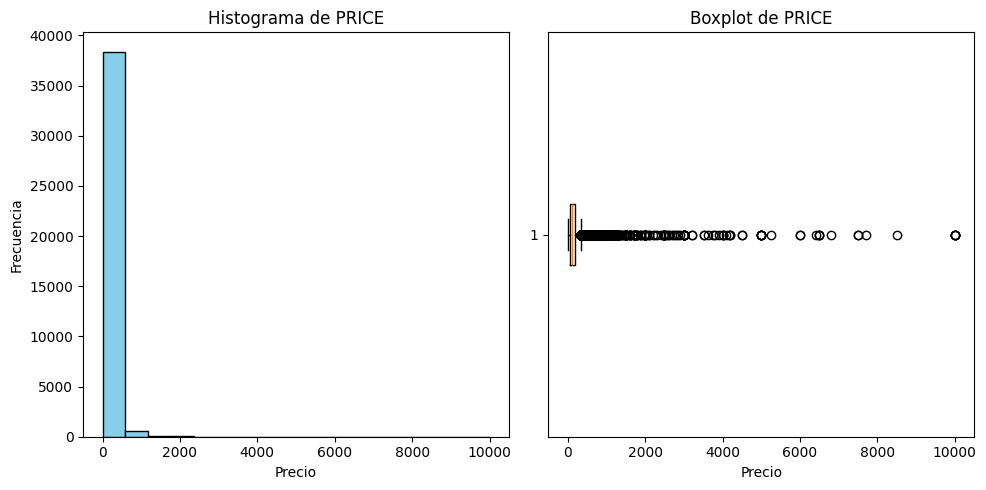

In [162]:
# Crear una figura con dos subplots (uno para el histograma y otro para el boxplot)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Crear un histograma en el primer subplot
ax[0].hist(y_train, bins='sturges', color='skyblue', edgecolor='black')
ax[0].set_title('Histograma de PRICE')
ax[0].set_xlabel('Precio')
ax[0].set_ylabel('Frecuencia')

# Crear un boxplot en el segundo subplot
ax[1].boxplot(y_train, vert=False)
ax[1].set_title('Boxplot de PRICE')
ax[1].set_xlabel('Precio')

# Mostrar la figura
plt.tight_layout()
plt.show()

In [163]:
y_train_clean.skew()

np.float64(18.58947933418074)

In [164]:
y_train_clean.describe()

,price
count,31718.000000
mean,155.423293
std,230.424039
min,0.000000
25%,70.000000
50%,110.000000
75%,180.000000
max,10000.000000


In [165]:
# Transformamos la variable respuesta en escala logarítmica

y_test = np.log(y_test)

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


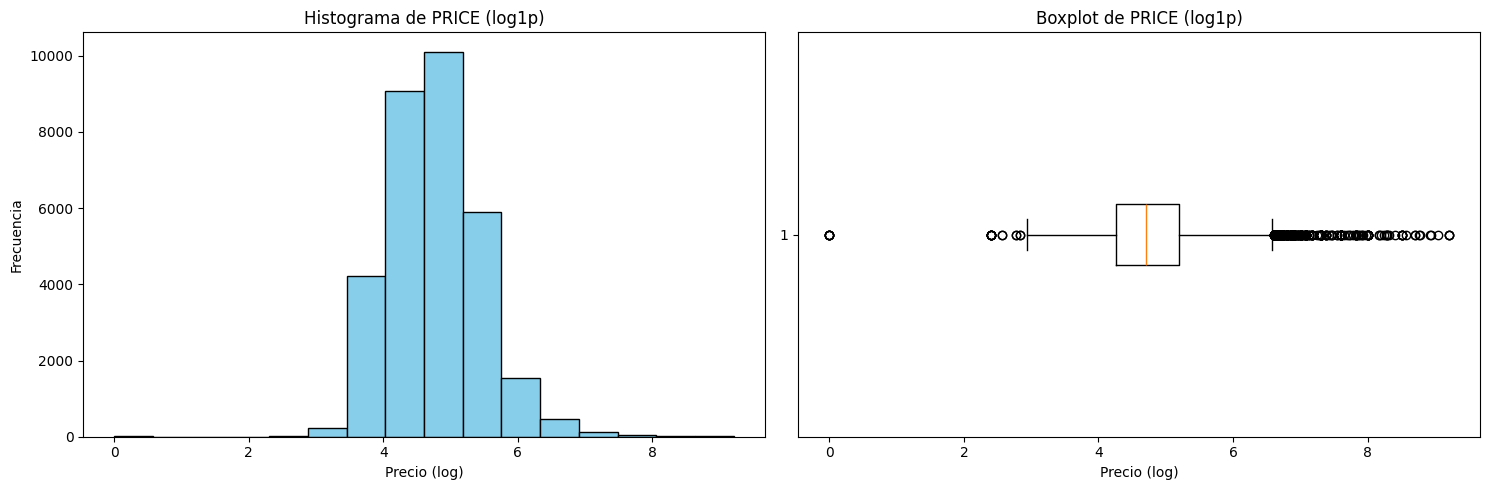

In [166]:
y_train_log = np.log1p(y_train_clean)
# Crear una figura con dos subplots (uno para el histograma y otro para el boxplot)
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].hist(y_train_log, bins='sturges', color='skyblue', edgecolor='black')
ax[0].set_title('Histograma de PRICE (log1p)')
ax[0].set_xlabel('Precio (log)')
ax[0].set_ylabel('Frecuencia')

# Boxplot en el segundo subplot
ax[1].boxplot(y_train_log, vert=False)
ax[1].set_title('Boxplot de PRICE (log1p)')
ax[1].set_xlabel('Precio (log)')

plt.tight_layout()
plt.show()

## **18.Escalar los datos**

In [167]:
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train_sel)
X_test_sc = scaler.transform(X_test_sel)

## **19.Cross_validation con Logaritmo en Y**

In [168]:
model = RandomForestRegressor(random_state=42, n_jobs=-1)

cv_results = cross_val_score(
    model,
    X_train_clean[features],
    y_train_log,
    cv=3,
    scoring='neg_mean_absolute_percentage_error'
)


print("Media MAE:", (-cv_results.mean()))

Media MAE: 3237018544584.3247


## **20.Filtrar el precio entre el 25 y 75 %**

In [169]:
Q1 = y_train.quantile(0.25)
Q3 = y_train.quantile(0.75)
IQR = Q3 - Q1

limite_inf = Q1 - 1.5 * IQR
limite_sup = Q3 + 1.5 * IQR

# Máscara para filtrar outliers
mask = (y_train >= limite_inf) & (y_train <= limite_sup)

# Filtrar X_train e y_train
X_train_filtrado = X_train.loc[mask]
y_train_filtrado = y_train.loc[mask]

In [170]:
limite_sup
y_train_filtrado.max()

334

In [171]:
print("Valores normales:", len(y_train_filtrado))
print("Valores eliminados:", len(y_train) - len(y_train_filtrado))

Valores normales: 36704
Valores eliminados: 2412


In [172]:
model = RandomForestRegressor(random_state=42, n_jobs=-1)

cv_results = cross_val_score(
    model,
    X_train_filtrado[features],
    y_train_filtrado,
    cv=3,
    scoring='neg_mean_absolute_error'
)

print("Media MAE:", -cv_results.mean())

Media MAE: 33.75307972112707


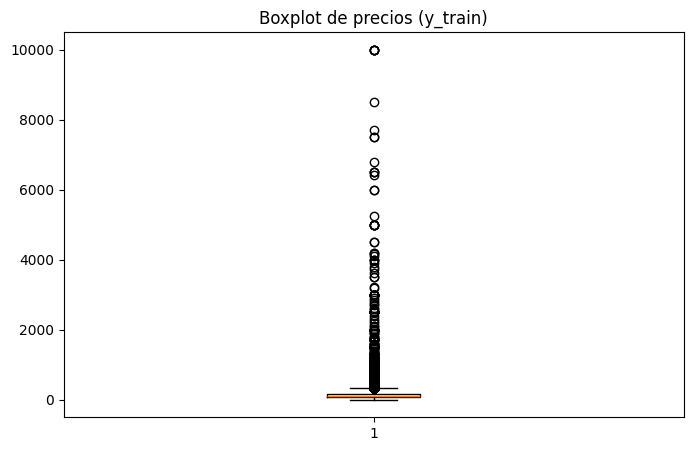

In [173]:
plt.figure(figsize=(8, 5))
plt.boxplot(y_train)
plt.title("Boxplot de precios (y_train)")
plt.show()



